# Jupyter Notebook 3: Data Preprocessing Steps - Feature Selection

---

# Introduction

At this point I want to investigate what are the most important features. There are 80 features in most of the data.

Most research in the Literature Review shows models that had very high results, too high and some other research showed this could be because the metadata (port, IP addresses, etc) had been left in. I will be removing these metadata features but for this notebook I want to invesitage different feature selection techniques to look at for any patterns.

---

# Feature Selection

Methods:
   - Heatmap based on correlations
   - Sequential Feature Selection
   - Forward Feature Selection
   - Backward Feature Selection
   - Feature Selection with Cross Validation
   - Decision Tree used as Feature Selection
   - Clustering 

---

# Libraries

In [1]:
# pip install mlxtend

In [18]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFECV

---

# Load data

In [3]:
# Load the file
data_1 = pd.read_parquet("data_1_processed.parquet")

---

# Feature Selection Methods: Data 1

## Heatmap based on correlations

### Create a Correlation Matrix

In [4]:
# Compute a correlation matrix
correlation_matrix = data_1.corr()

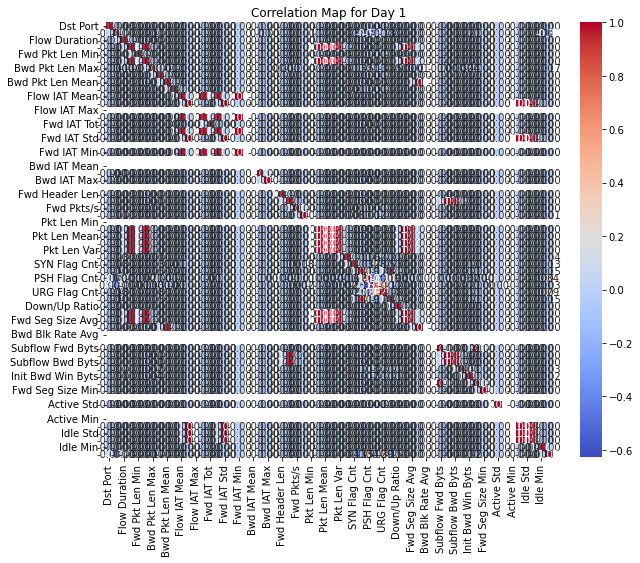

In [5]:
# plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Map for Day 1")
plt.show()

It is difficult to see the values. But we can see some strong correlations based on the color.

Instead, we can extract a list of which features are correlated.

### Get a list of the correlated pairs

In [6]:
# Set a correlation threshold above which we want to consider features as correlated
correlation_threshold = 0.7

# empty list for correlated pairs
correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            pair =  (correlation_matrix.columns[i], correlation_matrix.columns[j])
            correlated_pairs.append(pair)

In [7]:
print("Highly correlated feature pairs:")
for pair in correlated_pairs:
    print(pair)

Highly correlated feature pairs:
('Fwd Pkt Len Std', 'Fwd Pkt Len Max')
('Flow IAT Min', 'Flow IAT Mean')
('Fwd IAT Mean', 'Flow IAT Mean')
('Fwd IAT Mean', 'Flow IAT Min')
('Fwd IAT Std', 'Flow IAT Std')
('Fwd IAT Min', 'Flow IAT Mean')
('Fwd IAT Min', 'Flow IAT Min')
('Fwd IAT Min', 'Fwd IAT Mean')
('Pkt Len Max', 'Fwd Pkt Len Max')
('Pkt Len Max', 'Fwd Pkt Len Std')
('Pkt Len Mean', 'Fwd Pkt Len Max')
('Pkt Len Mean', 'Fwd Pkt Len Std')
('Pkt Len Mean', 'Pkt Len Max')
('Pkt Len Std', 'Fwd Pkt Len Max')
('Pkt Len Std', 'Fwd Pkt Len Std')
('Pkt Len Std', 'Pkt Len Max')
('Pkt Len Std', 'Pkt Len Mean')
('Pkt Len Var', 'Fwd Pkt Len Max')
('Pkt Len Var', 'Fwd Pkt Len Std')
('Pkt Len Var', 'Pkt Len Max')
('Pkt Len Var', 'Pkt Len Mean')
('Pkt Len Var', 'Pkt Len Std')
('ECE Flag Cnt', 'RST Flag Cnt')
('Pkt Size Avg', 'Fwd Pkt Len Max')
('Pkt Size Avg', 'Fwd Pkt Len Std')
('Pkt Size Avg', 'Pkt Len Max')
('Pkt Size Avg', 'Pkt Len Mean')
('Pkt Size Avg', 'Pkt Len Std')
('Pkt Size Avg', 'Pkt Len

### Removed the correlated pairs

In [8]:
# List of correlated pairs
correlated_pairs_list = [(pair[0], pair[1]) for pair in correlated_pairs]

# Remove this list from the data_1 featues and create a new dataset
columns_to_remove = [pair[1] for pair in correlated_pairs_list]
data_1_corr = data_1.drop(columns=columns_to_remove)

In [9]:
# Updated data
data_1_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046298 entries, 0 to 1046297
Data columns (total 44 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Dst Port           1046298 non-null  int8          
 1   Protocol           1046298 non-null  int8          
 2   Timestamp          1046298 non-null  datetime64[ns]
 3   Flow Duration      1046298 non-null  int8          
 4   Fwd Pkt Len Min    1046298 non-null  int8          
 5   Bwd Pkt Len Max    1046298 non-null  int8          
 6   Bwd Pkt Len Min    1046298 non-null  int8          
 7   Bwd Pkt Len Std    1046298 non-null  int8          
 8   Flow IAT Max       1046298 non-null  int8          
 9   Fwd IAT Tot        1046298 non-null  int8          
 10  Fwd IAT Max        1046298 non-null  int8          
 11  Fwd IAT Min        1046298 non-null  int8          
 12  Bwd IAT Tot        1046298 non-null  int8          
 13  Bwd IAT Mean       1046298 

## Sequential Feature Selection: Bidirectional

In [10]:
# Have a working dataset for the Sequential Feature Selection
data_1_bidir = data_1

data_1_bidir.drop(columns=["Timestamp"], inplace=True)

In [11]:
# Set the X and y datasets and train with the Linear Regression model
X= data_1_bidir.drop(columns=["Label"])
y= data_1_bidir["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model # Use Linear regression for an example
model = LinearRegression()

# Initialize the Sequential Feature Selector
sfs = SequentialFeatureSelector(model, k_features=20, forward=True, 
                                floating=True, verbose=2, scoring='r2', cv=10)

# Look at the feature selection
sfs.fit(X_train, y_train)
selected_features = sfs.k_feature_idx_

# Get the feature names
selected_feature_names = [X.columns[idx] for idx in selected_features]

print("Selected features for Bidirectional Feature Selection:", selected_feature_names)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   13.2s

[2023-07-22 22:59:37] Features: 1/20 -- score: 0.14160549166267336[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   25.3s

[2023-07-22 23:00:15] Features: 2/20 -- score: 0.19128290613123278[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   29.8s

[2023-07-22 23:01:00] Features: 3/20 -- score: 0.33097766030073655[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   34.8s

[2023-07-22 23:01:53] Features: 4/20 -- score: 0.3904708214759367[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   41.5s

[2023-07-22 23:02:56] Features: 5/20 -- score: 0.4514912540636815[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   47.6s

[2023-07-22 23:04:08] Features: 6/20 -- score: 0.45283333192531094[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   54.9s

[2023-07-22 23:05:31] Features: 7/20 -- score: 0.4531905902647466[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.0min

[2023-07-22 23:07:06] Features: 8/20 -- score

Selected features for Bidirectional Feature Selection: ['Dst Port', 'Protocol', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Flow IAT Mean', 'Bwd IAT Max', 'Bwd Pkts/s', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'Bwd Seg Size Avg', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Active Std']



[2023-07-22 23:52:52] Features: 20/20 -- score: 0.4532057340900605

Selected features for Bidirectional Feature Selection: **'Protocol', 'Bwd Pkt Len Max', 'RST Flag Cnt', 'PSH Flag Cnt', 'URG Flag Cnt'**

## Forward Feature Selection

In [12]:
# get a working dataset for Forward Feature Selection
data_1_forw = data_1

In [13]:
X= data_1_forw.drop(columns=["Label"])
y= data_1_forw["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model # Use Linear regression for an example
model = LinearRegression()

# Initialize the Sequential Feature Selector
sfs = SequentialFeatureSelector(model, k_features=20, forward=True, 
                                floating=False, verbose=2, scoring='r2', cv=10)

# Look at the feature selection
sfs.fit(X_train, y_train)
selected_features = sfs.k_feature_idx_

# Get the feature names
selected_feature_names = [X.columns[idx] for idx in selected_features]

print("Selected features for Forward Feature Selection:", selected_feature_names)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   12.8s

[2023-07-22 23:53:12] Features: 1/20 -- score: 0.14160549166267336[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   24.3s

[2023-07-22 23:53:49] Features: 2/20 -- score: 0.19128290613123278[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   28.8s

[2023-07-22 23:54:31] Features: 3/20 -- score: 0.33097766030073655[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   34.0s

[2023-07-22 23:55:21] Features: 4/20 -- score: 0.3904708214759367[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   39.6s

[2023-07-22 23:56:17] Features: 5/20 -- score: 0.4514912540636815[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   46.1s

[2023-07-22 23:57:22] Features: 6/20 -- score: 0.45283333192531094[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   52.6s

[2023-07-22 23:58:34] Features: 7/20 -- score: 0.4531905902647466[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.0min

[2023-07-22 23:59:56] Features: 8/20 -- score

Selected features for Forward Feature Selection: ['Dst Port', 'Protocol', 'Fwd Pkt Len Max', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Flow IAT Mean', 'Bwd IAT Max', 'Bwd Pkts/s', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'Bwd Seg Size Avg', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Active Std']



[2023-07-23 00:30:28] Features: 20/20 -- score: 0.4532057340900605

**'Protocol', 'Bwd Pkt Len Max', 'RST Flag Cnt', 'PSH Flag Cnt', 'URG Flag Cnt'** these features contributed to the models the best. 

We will come back to this again later.

## Backward Feature Selection

In [14]:
# get a working dataset for Forward Feature Selection
data_1_back = data_1

In [15]:
X= data_1_back.drop(columns=["Label"])
y= data_1_back["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model # Use Linear regression for an example
model = LinearRegression()

# Initialize the Sequential Feature Selector
sfs = SequentialFeatureSelector(model, k_features=20, forward=False, 
                                floating=False, verbose=2, scoring='r2', cv=10)

# Look at the feature selection
sfs.fit(X_train, y_train)
selected_features = sfs.k_feature_idx_

# Get the feature names
selected_feature_names = [X.columns[idx] for idx in selected_features]

print("Selected features for Backward Feature Selection:", selected_feature_names)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 11.3min

[2023-07-23 00:47:57] Features: 60/20 -- score: -2.2646447865255738e+17[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 11.2min

[2023-07-23 01:04:43] Features: 59/20 -- score: -9.260052097136394e+16[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 10.9min

[2023-07-23 01:20:47] Features: 58/20 -- score: -5.945458337777344e+16[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 10.7min

[2023-07-23 01:36:21] Features: 57/20 -- score: -1.2157646370277676e+16[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 10.4min

[2023-07-23 01:51:09] Features: 56/20 -- score: -1.22040438827117e+16[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 10.3min

[2023-07-23 02:05:31] Features: 55/20 -- score: -4.872460940968582e+16[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 10.0min

[2023-07-23 02:19:19] Features: 54/20 -- score: -1.0611004883595598e+17[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  9.8min

[2023-07-23 

Selected features for Backward Feature Selection: ['Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Flow IAT Max', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Idle Mean']



[2023-07-23 05:58:21] Features: 20/20 -- score: 0.39047003522134105

## Feature Selection with Cross Validation

In [16]:
# get a working dataset for Forward Feature Selection
data_1_cv = data_1

In [20]:
X= data_1_cv.drop(columns=["Label"])
y= data_1_cv["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model # Use Linear regression for an example
model = LinearRegression()

# Initialize the Sequential Feature Selector
rfecv = RFECV(model, step=1, cv=10, scoring="r2", min_features_to_select=20)

# Look at the feature selection
rfecv.fit(X_train, y_train)
selected_features =rfecv.support_

# Get the feature names
selected_feature_names = [X.columns[idx] for idx in selected_features]

print("Selected features for Feature Selection using Cross Validation:", selected_feature_names)

Selected features for Feature Selection using Cross Validation: [array([], shape=(0, 61), dtype=object), array([], shape=(0, 61), dtype=object), array([], shape=(0, 61), dtype=object), array([['Dst Port', 'Protocol', 'Flow Duration', 'Fwd Pkt Len Max',
        'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
        'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
        'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
        'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
        'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std',
        'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len',
        'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
        'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
        'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
        'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
        'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'B

## Decision Tree used as Feature Selection

In [21]:
# get a working dataset for Forward Feature Selection using a Decision Tree
data_1_dt = data_1

In [22]:
X= data_1_dt.drop(columns=["Label"])
y= data_1_dt["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model # Use Decision Tree for an example
model = DecisionTreeRegresssor()

# Fit the model
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Sort features by importance
sorted_features = feature_importance.argsort()[::-1]
selected_features = sorted_indices[:20]

# Get the feature names
selected_feature_names = [X.columns[idx] for idx in selected_features]

print("Selected features for Feature Selection Using a Decions Tree:", selected_feature_names)

NameError: name 'DecisionTreeRegresssor' is not defined

## Clustering 

--- 

In [ ]:
print("Notebook ran fully. No issues.")

---